# How to plot spatial gene expression estimates created with the splotch DE workflow?



This script recreates figure S7C (DAPI+IF) in SM-Omics: An automated platform for high-throughput spatial multi-omics; doi: https://doi.org/10.1101/2020.10.14.338418

Load libraries

In [2]:
from __future__ import absolute_import, division, print_function
import os
import re
import glob
import numpy
import matplotlib
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import math
import seaborn as sns
from PIL import Image
Image.MAX_IMAGE_PIXELS = 1000000000

%matplotlib inline
matplotlib.rcParams.update({'axes.linewidth': 0.25,
                            'xtick.major.size': 2,
                            'xtick.major.width': 0.25,
                            'ytick.major.size': 2,
                            'ytick.major.width': 0.25,
                            'pdf.fonttype': 42,
                            'font.sans-serif': 'Arial'})

ModuleNotFoundError: No module named 'seaborn'

In [ ]:
# raw data files needed to run are available at SCP: https://singlecell.broadinstitute.org/single_cell/study/SCP979/
# please download: lambdas_pmeans_dapi+if.tsv, coordinate_registration_dapi+if.p, information_dapi+if.p

Load definitions

In [ ]:
def read_array_metadata(metadata,filename,n_levels, extraplot=None):
    array_metadata = metadata[metadata['Count file'] == filename]
    array_levels = [array_metadata['Level %d'%(idx+1)].values[0] for idx in range(0,n_levels)]
    
    if extraplot != None:
        array_levels = array_metadata['Extra_plot_level'].tolist()
    return array_levels

def Extract(lst): 
    return list(next(zip(*lst))) 

def rename_lambdas_index(lambdas_file): 
    nwe=[]
    nm=lambdas_file.index
    for item in nm:
        nwe.append(str(item).split("_")[0])
    return nwe

In [ ]:
# Load Lambda pmean df

path = '/Users/svickovi/Desktop/splotch/splotch_STB47_Nestin'

# Read file
filename = os.path.join(path, 'lambdas_pmeans_dapi+if.tsv')
lambda_posterior_means = pd.read_csv(filename, index_col=0, sep='\t', header=[0,1],low_memory=False)
lambda_posterior_means.index = rename_lambdas_index(lambda_posterior_means)


In [3]:
# Load coordinates registration file
reg_file = os.path.join(path, 'coordinate_registration_dapi+if.p')
registered_coordinates_dict = pickle.load(open(reg_file,'rb'), encoding='bytes') 


In [4]:
registered_coordinates_dict

{'/ahg/regevdata/projects/splotch_spatial_transcriptomics/outputs/splotch/STB_FL_HE_cortex/cortex/output_NewNestin/Count_Tables/10015CN108fl_C1_stdata_adjusted.tsv': {'31_9': '-4.42889_16.270185',
  '16_25': '3.4433794_-4.199972',
  '28_7': '-0.8966412_16.993523',
  '31_20': '-8.57038_6.0795994',
  '14_12': '10.190702_7.0904517',
  '27_30': '-8.6297035_-4.6905675',
  '20_28': '-1.391786_-5.473227',
  '19_26': '0.28762943_-3.996891',
  '26_10': '-0.17330545_13.461273',
  '27_7': '0.029774256_16.617023',
  '21_24': '-0.8122065_-1.3910593',
  '20_16': '3.1262028_5.643778',
  '22_8': '4.2853622_13.808111',
  '21_27': '-1.9417037_-4.17031',
  '27_27': '-7.500206_-1.9113158',
  '14_20': '7.1787086_-0.32088506',
  '28_16': '-4.2851334_8.655769',
  '25_10': '0.7531124_13.084775',
  '8_22': '11.984213_-4.4327126',
  '10_25': '9.001882_-6.458966',
  '9_18': '12.563792_-0.35054648',
  '16_18': '6.078873_2.284947',
  '9_19': '12.187293_-1.2769634',
  '25_17': '-1.882381_6.599856',
  '31_10': '-4.8

In [58]:
# Load sample_information file
info_file = os.path.join(path, 'information_dapi+if.p')
info = pickle.load(open(info_file,'rb'))   
metadata = info['metadata']
n_levels = info['n_levels']


In [12]:
# Take exp()
lambda_posterior_means = lambda_posterior_means.astype(float)
lambda_posterior_means = numpy.exp(lambda_posterior_means-1)

/Users/svickovi/miniconda3/envs/stenv3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


## Plot a single gene across all different spatial arrays

In [42]:
# Pick a gene:
gene = 'Mbp'

assert gene in lambda_posterior_means.index, 'Error: %s not found!'%(gene)

# Pick variables to compare
variables_of_interest = ['M1']

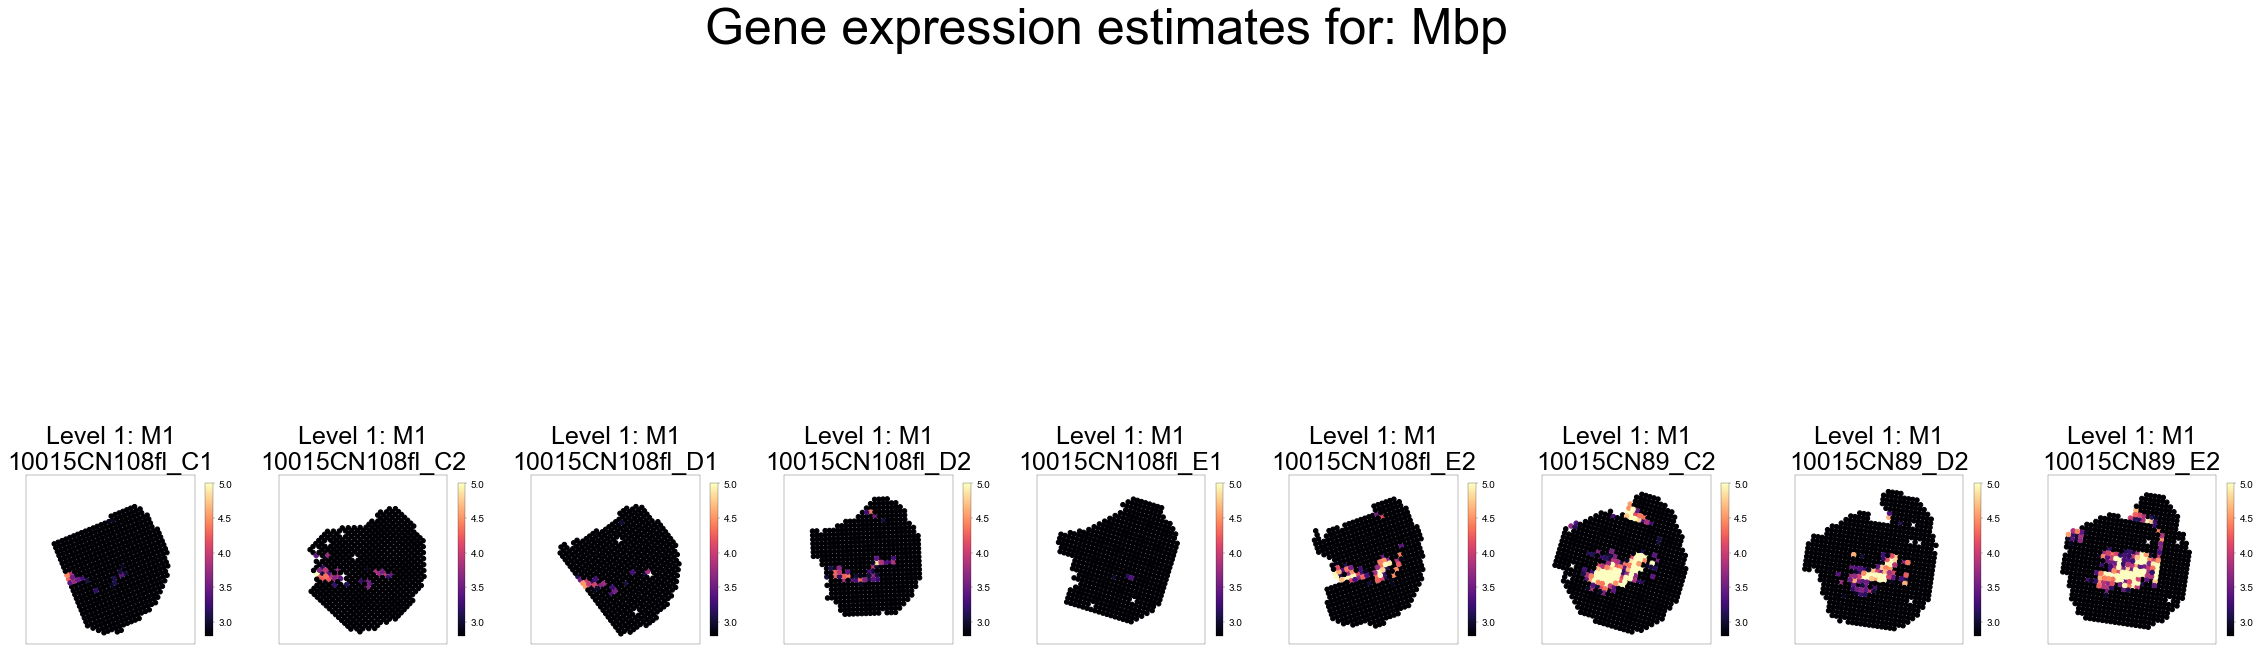

In [45]:
# initialize a figure
fig = matplotlib.pyplot.figure(figsize=(40, 30))

num_cols = 9

axes = []
for j in range(0, num_cols):
    ax = plt.subplot2grid((int(len(count_files)/num_cols+1), num_cols), (0, j))
    axes.append(ax) 

# get the names of the count files
count_files = numpy.array(list(lambda_posterior_means.columns.levels[0]))

# use the same color scale across the arrays
vmin,vmax = 5,numpy.percentile(lambda_posterior_means.loc[gene].values,90)

fig.suptitle("Gene expression estimates for: " + gene, fontsize=50)

# loop over the count files
for n,count_file in enumerate(count_files):
    ax = axes[n]

    coordinates = []
    for coord_idx,coordinate in enumerate(list(lambda_posterior_means[count_file].columns)):
        if coordinate in registered_coordinates_dict[count_file]:
            
            coordinates.append(list(map(float,registered_coordinates_dict[count_file][coordinate].split('_'))))
    coordinates = numpy.array(coordinates) 
    
    x_coordinates = coordinates[:,0]
    y_coordinates = coordinates[:,1]
    
    if n in [0, 1, 2]:
        alpha = 180
        x_coordinates = math.cos(math.radians(alpha))* coordinates[:,0]-math.sin(math.radians(alpha))*coordinates[:,1]
        y_coordinates = math.sin(math.radians(alpha))* coordinates[:,0]+math.cos(math.radians(alpha))*coordinates[:,1] 
        x_coordinates = max(x_coordinates)-x_coordinates+min(x_coordinates)
    else:
        x_coordinates = coordinates[:,0]
        y_coordinates = coordinates[:,1]
    
    s=20
    cbmap = ax.scatter(x_coordinates,y_coordinates,
                       s=s,c=lambda_posterior_means[count_file].loc[gene],
                       cmap='magma',vmin=vmin,vmax=vmax,marker='o')
    
    ax.set_aspect('equal')
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    
        # put some information on the array in the title
    ax.set_title('%s\n%s'%(
                '\n'.join(['Level %d: %s'%(level_idx+1,level)
                       for level_idx,level in enumerate(list(map(str,read_array_metadata(metadata,count_file,n_levels))))]),count_file.split('/')[-1].split("_stdata_adjusted.tsv")[0]), fontsize=25)
    
    cbar = matplotlib.pyplot.colorbar(cbmap,ax=ax,shrink=0.2)
    cbar.ax.tick_params(labelsize=10) 
        
fig.subplots_adjust(top=0.90)

## View multiple genes at once in a CCF system

In [87]:
# Pick genes:
genes = ['Nxph4','Doc2a', 'Slc18a2', 'Cabp7','Ptpn4','Scn5a', 'Phactr2', 'Dkkl1', 'Mbp']

for gene in genes:
    assert gene in lambda_posterior_means.index, 'Error: %s not found!'%(gene)

# Pick variables to compare
variables_of_interest = ['M1']
naming_dict = {'M1':'Cortex DAPI+IF samples, splotch_one_level'}

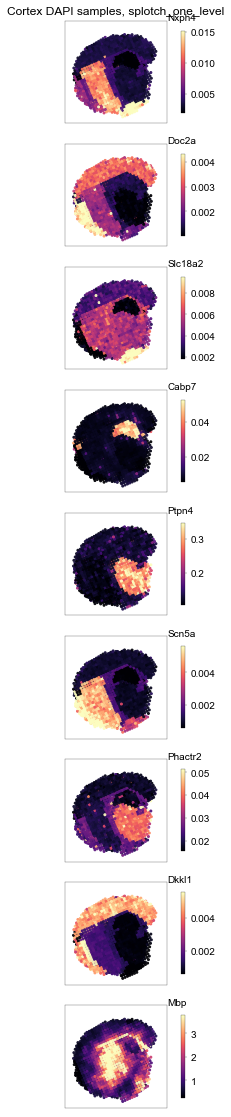

In [88]:
# initialize a figure
fig = matplotlib.pyplot.figure()
fig.set_size_inches([len(variables_of_interest)*5,20])

axes = []
for i in range(len(genes)):
    for ax_idx in range(len(variables_of_interest)):
        ax = plt.subplot2grid((len(genes), len(variables_of_interest)), (i, ax_idx))
        axes.append(ax)                    

for gidx, gene in enumerate(genes):
    
    # get the names of the count files
    count_files = numpy.array(list(lambda_posterior_means.columns.levels[0]))
    
    #count_files = count_files[0:2]

    # use the same color scale across the arrays
    #vmin,vmax = 0,numpy.percentile(lambda_posterior_means.loc[gene].values,95)
    vmin = numpy.percentile(lambda_posterior_means.loc[gene].values,5)
    vmax = numpy.percentile(lambda_posterior_means.loc[gene].values,95)
    
    # adjust the axes
    for ax_idx in range(0,len(variables_of_interest)):
        
        if gidx == 0:
            axes[ax_idx +(gidx*len(variables_of_interest))].set_title(naming_dict[variables_of_interest[ax_idx]])
    
        axes[ax_idx +(gidx*len(variables_of_interest))].set_aspect('equal')
    
        axes[ax_idx +(gidx*len(variables_of_interest))].set_xticks([])
        axes[ax_idx +(gidx*len(variables_of_interest))].set_yticks([])
    
        axes[ax_idx +(gidx*len(variables_of_interest))].set_xlim([-20,20])
        axes[ax_idx +(gidx*len(variables_of_interest))].set_ylim([-20,20])

    cbmap = [None for _ in range(0,len(variables_of_interest))]
    
    # loop over the count files
    for n,count_file in enumerate(count_files):
    
        # see if the current array has the level variable of interest
        try:
            #ax_idx = variables_of_interest.index(read_array_metadata(metadata,count_file,n_levels)[0])
            ax_idx = variables_of_interest.index(read_array_metadata(metadata,count_file,n_levels)[0])
        except ValueError:
            continue
        
        # move to the next array if the current array has not been registered 
        if count_file not in registered_coordinates_dict:
            continue
    
        # for each ST spot on the array, let us get its registered coordinate if available
        coordinates_found = numpy.zeros(len(list(lambda_posterior_means[count_file].columns))) # indicator of being registered
        coordinates = []  
        for coord_idx,coordinate in enumerate(list(lambda_posterior_means[count_file].columns)):
            if coordinate in registered_coordinates_dict[count_file]:
                coordinates_found[coord_idx] = 1
                coordinates.append(list(map(float,registered_coordinates_dict[count_file][coordinate].split('_'))))
        coordinates = numpy.array(coordinates)
        
        x_coordinates = coordinates[:,0]
        y_coordinates = coordinates[:,1]
        
        ##  Rotation specific for DAPI 9 sections dataset
        if n in [0, 1, 2]:
            alpha = 15
            x_coordinates = math.cos(math.radians(alpha))* coordinates[:,0]-math.sin(math.radians(alpha))*coordinates[:,1]
            y_coordinates = math.sin(math.radians(alpha))* coordinates[:,0]+math.cos(math.radians(alpha))*coordinates[:,1]
            mn = min(x_coordinates)
            mny = min(y_coordinates)
            y_coordinates = max(y_coordinates)-y_coordinates+mny
        else:
            x_coordinates = coordinates[:,0]
            y_coordinates = coordinates[:,1]
        
        alpha = 0
        x_coordinates1 = math.cos(math.radians(alpha))* x_coordinates-math.sin(math.radians(alpha))*y_coordinates
        y_coordinates1 = math.sin(math.radians(alpha))* x_coordinates+math.cos(math.radians(alpha))*y_coordinates
        y_coordinates2 = max(y_coordinates1)- y_coordinates1 +min(y_coordinates1)
        
        alpha = 105
        x_coordinates3 = math.cos(math.radians(alpha))* x_coordinates1-math.sin(math.radians(alpha))*y_coordinates2
        y_coordinates3 = math.sin(math.radians(alpha))* x_coordinates1+math.cos(math.radians(alpha))*y_coordinates2
      
    
        # visualize the registered ST spots
        cbmap[ax_idx] = axes[ax_idx +(gidx*len(variables_of_interest))].scatter(x_coordinates3,y_coordinates3,
                               s=4, c=lambda_posterior_means[count_file].loc[gene][coordinates_found > 0],
                               cmap='magma',vmin=vmin,vmax=vmax,marker='o',alpha=0.9)

    # add colorbars
    for ax_idx in range(0, len(variables_of_interest)):
        if cbmap[ax_idx] is not None:
            cbar = matplotlib.pyplot.colorbar(cbmap[ax_idx],ax=axes[ax_idx +(gidx*len(variables_of_interest))],shrink=0.8)    
            #cbar.set_label(r'%s $\bar{\lambda}$'%(gene))
    
    # Set gene name
    uu = 0
    axes[uu +(gidx*len(variables_of_interest))].text(20, 20, gene, fontsize=10)


# Plot individually sections

In [89]:
# Pick genes:
regions = ['CTXSP', 'HIP', 'HY', 'ISOCORTEX', 'TH', 'CNU', 'PIR']  
genes = ['Nr2f2','Cabp7','Sema4g','Dkkl1','Slc17a6', 'Penk', 'Grem2'] 

# Pick variables to compare
variables_of_interest = ['M1']

In [90]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [91]:
aba_path = '/Users/svickovi/Desktop/splotch/jpg_he'
ABA_HE = [aba_path + '/' + genes[0] + '.jpg',
         aba_path + '/' + genes[1] + '.jpg',
         aba_path + '/' + genes[2] + '.jpg',
         aba_path + '/' + genes[3] + '.jpg',
         aba_path + '/' + genes[4] + '.jpg',
         aba_path + '/' + genes[5] + '.jpg',
         aba_path + '/' + genes[6] + '.jpg']


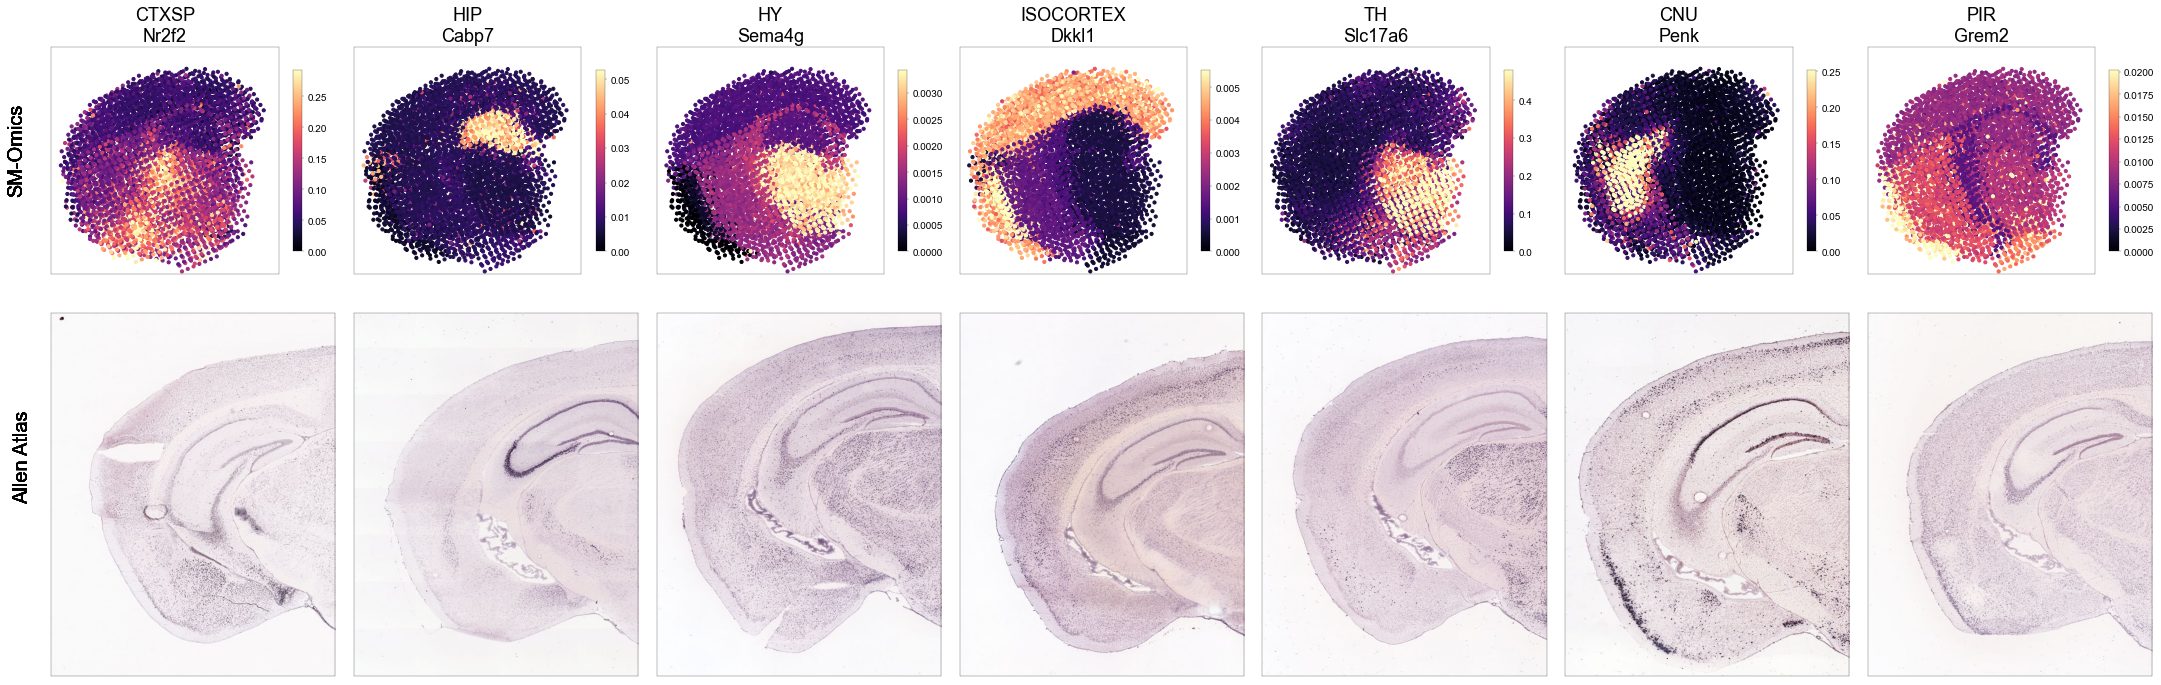

In [100]:
## Same, but one gene in each figure, ie. no subplots

# initialize a figure
fig = matplotlib.pyplot.figure(figsize=(30, 10))

axes = []
for ax_idx in range(0,2):
    for i in range(len(genes)):
        ax = plt.subplot2grid((2, len(genes)), (ax_idx, i))
        axes.append(ax)                    


############# SPLOTCH ############# 
for gidx, gene in enumerate(genes):
    
    # get the names of the count files
    count_files = numpy.array(list(lambda_posterior_means.columns.levels[0]))

    # use the same color scale across the arrays
    vmin,vmax = 0,numpy.percentile(lambda_posterior_means.loc[gene].values,95)
           
    
    axes[gidx].set_aspect('equal')
    
    axes[gidx].set_xticks([])
    axes[gidx].set_yticks([])
    
    axes[gidx].set_xlim([-18,18])
    axes[gidx].set_ylim([-18,18])

    cbmap = [None for _ in range(0,len(genes))]
    
    # loop over the count files
    for n,count_file in enumerate(count_files):
    
        # see if the current array has the level variable of interest
        try:
            #ax_idx = variables_of_interest.index(read_array_metadata(metadata,count_file,n_levels)[0])
            ax_idx = variables_of_interest.index(read_array_metadata(metadata,count_file,n_levels)[0])
        except ValueError:
            continue
        
        # move to the next array if the current array has not been registered 
        if count_file not in registered_coordinates_dict:
            continue
    
        # for each ST spot on the array, let us get its registered coordinate if available
        coordinates_found = numpy.zeros(len(list(lambda_posterior_means[count_file].columns))) # indicator of being registered
        coordinates = []  
        for coord_idx,coordinate in enumerate(list(lambda_posterior_means[count_file].columns)):
            if coordinate in registered_coordinates_dict[count_file]:
                coordinates_found[coord_idx] = 1
                coordinates.append(list(map(float,registered_coordinates_dict[count_file][coordinate].split('_'))))
        coordinates = numpy.array(coordinates)
        x_coordinates = coordinates[:,0]
        y_coordinates = coordinates[:,1]
        
##  Rotation specific for DAPI 9 sections dataset
        if n in [0, 1, 2]:
            alpha = 15
            x_coordinates = math.cos(math.radians(alpha))* coordinates[:,0]-math.sin(math.radians(alpha))*coordinates[:,1]
            y_coordinates = math.sin(math.radians(alpha))* coordinates[:,0]+math.cos(math.radians(alpha))*coordinates[:,1]
            mn = min(x_coordinates)
            mny = min(y_coordinates)
            y_coordinates = max(y_coordinates)-y_coordinates+mny
        else:
            x_coordinates = coordinates[:,0]
            y_coordinates = coordinates[:,1]
        
        alpha = 0
        x_coordinates1 = math.cos(math.radians(alpha))* x_coordinates-math.sin(math.radians(alpha))*y_coordinates
        y_coordinates1 = math.sin(math.radians(alpha))* x_coordinates+math.cos(math.radians(alpha))*y_coordinates
        y_coordinates2 = max(y_coordinates1)- y_coordinates1 +min(y_coordinates1)
        
        alpha = 105
        x_coordinates3 = math.cos(math.radians(alpha))* x_coordinates1-math.sin(math.radians(alpha))*y_coordinates2
        y_coordinates3 = math.sin(math.radians(alpha))* x_coordinates1+math.cos(math.radians(alpha))*y_coordinates2

        # visualize the registered ST spots
        cbmap[gidx] = axes[gidx].scatter(x_coordinates3,y_coordinates3,
                               s=10, c=lambda_posterior_means[count_file].loc[gene][coordinates_found > 0],
                               cmap='magma',vmin=vmin,vmax=vmax,marker='o')

    # add colorbars
    for ax_idx in range(0, len(genes)):
        if cbmap[ax_idx] is not None:
            cbar = matplotlib.pyplot.colorbar(cbmap[ax_idx],ax=axes[gidx],shrink=0.5)    
            #cbar.set_label(r'%s $\bar{\lambda}$'%(gene))
     
    # Set sub labels
    axes[0].text(-25, -5, 'SM-Omics', fontsize=20,  rotation=90)
    
    # Set gene name
    uu =0
    axes[gidx].set_title(regions[gidx] + '\n' + gene, fontsize=18)
    
############# ABA expression ############# 

for j, genej in enumerate(genes):
    
    # read the tissue image
    tissue_image = Image.open(ABA_HE[j])
    tissue_image = matplotlib.pyplot.imread(ABA_HE[j])
    # take only half 
        
    # visualize the tissue image
    axes[j+7].imshow(tissue_image[:,0:round(numpy.size(tissue_image,0)/2)+100])
    #axes[j+7].imshow(tissue_image)
    axes[j+7].set_aspect('auto')
    
    axes[j+7].set_xticks([])
    axes[j+7].set_yticks([])
    
    # Set sublabels
    axes[7].text(-80, 500, 'Allen Atlas', fontsize=20,  rotation=90)
    
plt.tight_layout()
plt.show()
#plt.savefig('DAPI+IF_mrna_splotch.pdf',transparent=True, bbox_inches = 'tight',
#    pad_inches = 0, dpi=1200, rasterized=True)
